In [44]:
pip install --upgrade ipywidgets notebook

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--:--
   -------- ------------------------------ 30.7/139.4 kB 217.9 kB/s eta 0:00:01
   -------- ------------------------------ 30.7/139.4 kB 217.9 kB/s eta 0:00:01
   -------- ------------------------------ 30.7/139.4 kB 217.9 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.4 kB 192.5 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.4 kB 192.5 kB/s eta 0:00:01
   -------------------- ------------------ 71.7/139.4 kB 186.7 kB/s eta 0:00:01
   -------------------- ------------------ 71.7/139.4 kB 186.7 kB/s eta 0:00:01
   -------------------- ------------------ 71.7/139.4 kB 186.7 kB/s eta 0:00

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
     --- ------------------------------------ 0.4/4.9 MB 12.5 MB/s eta 0:00:01
     ------------ --------------------------- 1.6/4.9 MB 20.0 MB/s eta 0:00:01
     ------------------------- -------------- 3.1/4.9 MB 24.7 MB/s eta 0:00:01
     ---------------------------------------- 4.9/4.9 MB 31.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ---------- ----------------------------- 1.1/4.0 MB 71.0 MB/s eta 0:00:01
     ---------------------------------------  4.0/4.0 MB 50.7 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 42.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 90.9 MB/s eta 0:00:30
     -------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.


In [1]:
pip install cuda_python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytorch_lightning

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/801.6 kB ? eta -:--:--
   ------- -------------------------------- 143.4/801.6 kB 4.3 MB/s eta 0:00:01
   ----------------------- ---------------- 471.0/801.6 kB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 801.6/801.6 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/841.5 kB ? eta -:--:--
   ---------------------------------- ---- 747.5/841.5 kB 16.0 MB/s eta 0:00:01
   --------------------------------------- 841.5/841.5 kB 13.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
import numpy as np
import time
import os
import h5py
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import pytorch_lightning as pl
from matplotlib import pyplot as plt

directory = 'C:/Users/arwilzman/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/Desktop/ICBIN_B/Data/'

In [2]:
class Chamfer_Loss(nn.Module):
    def __init__(self):
        super(Chamfer_Loss, self).__init__()        
    def forward(self, inputs, preds):
        return self.compute_chamfer_loss(inputs, preds)
                
    def compute_chamfer_loss(self, inputs, preds):
        loss = self.compute_loss(inputs, preds)
        
        self.clip_gradients() # only you can prevent gradient explosions
        
        return loss
    
    def clip_gradients(self):
        # Iterate through all parameters
        for param in self.parameters():
            if param.grad is not None:
                nn.utils.clip_grad_norm_(param, self.clip_threshold)

    def compute_loss(self, cloud1, cloud2):
        # Compute squared Euclidean distances using broadcasting and vectorized operations
        diff = cloud1.unsqueeze(2) - cloud2.unsqueeze(1)  # Shape: (batch_size, num_points_cloud1, num_points_cloud2, 3)
        distances_squared = torch.sum(diff ** 2, dim=-1)  # Shape: (batch_size, num_points_cloud1, num_points_cloud2)
        
        # Find the mean minimum distance along the second and third dimension
        min_distances1, _ = torch.min(distances_squared, dim=1)
        min_distances2, _ = torch.min(distances_squared, dim=2)
        min1 = torch.mean(min_distances1)
        min2 = torch.mean(min_distances2)
        
        # Take the max
        return max(min1, min2)

In [3]:
class GAN_Loss(nn.Module):
    def __init__(self, penalty_weight=0.1):
        super(GAN_Loss, self).__init__()
        self.penalty_weight = penalty_weight
        self.guess_loss = nn.L1Loss()
    
    def forward(self, predicted, actual, pred_cloud=None, tgt_cloud=None):
        # Compute the L1 loss between predicted and actual
        loss = self.guess_loss(predicted, actual)
        
        # If predicted point cloud and target point cloud are provided, compute KL divergence loss
        if pred_cloud is not None and tgt_cloud is not None:
            loss_cloud = Chamfer_Loss(pred_cloud, tgt_cloud)
            loss += loss_cloud
        
        return loss

In [4]:
class MTDataset(Dataset):
    def __init__(self, file_paths, num_points=1300):
        self.file_paths = file_paths
        self.num_points = num_points
        self.data = []  # List to store loaded data
        
        # Load data from file_paths into memory
        for file_path in self.file_paths:
            with h5py.File(file_path, 'r') as hf:
                bone = hf['Surface'][:] # 6,000 3d Cartesian points, surface only
                densities = hf['Pointcloud'] # 30,000 3d Cartesian points with density column
                mt_no = int(np.array(hf['MTno']))
                side = np.array(hf['Side'])
                if 'L' in str(side):
                    side_int = 0 #Left is 0
                else:
                    side_int = 1 #Right is 1
                    
                num_samples_surf = min(self.num_points, bone.shape[0])
                num_samples_dens = min(self.num_points, densities.shape[0])
                # Randomly sample num_samples indices from the bone dataset
                sampled_indices_surf = torch.randperm(bone.shape[0])[:num_samples_surf]
                sampled_indices_dens = torch.randperm(densities.shape[0])[:num_samples_dens]
                sorted_indices_surf = torch.sort(sampled_indices_surf)[0]
                sampled_bone = bone[sorted_indices_surf]
                sorted_indices_dens = torch.sort(sampled_indices_dens)[0]
                sampled_dens = densities[sorted_indices_dens]
                # Store the sampled data in self.data
                self.data.append({'surf': torch.FloatTensor(sampled_bone), 'dens': torch.FloatTensor(sampled_dens),
                                  'mt_no': torch.tensor(mt_no, dtype=torch.int8), 'side': torch.tensor(side_int, dtype=torch.int8)})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
class arw_lightning(pl.LightningModule):
    def __init__(self, network, loss_function, learning_rate, wtdecay, print_interval, input_cols=''):
        super(arw_lightning, self).__init__()
        self.network = network
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.wtdecay = wtdecay
        self.print_interval = print_interval
        self.input_cols = input_cols
        self.training_losses = []  # To store training losses

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        output = self.network(batch)
        loss = self.loss_function(output, batch)
        self.training_losses.append(loss.item())  # Store the loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.wtdecay)
        return optimizer


In [6]:
def train_autoencoder(train_dataset, network, epochs, learning_rate, wtdecay, batch_size, print_interval, device, input_cols='', workers=4):
    model = network  # Use the provided network instance
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=workers, shuffle=True, persistent_workers=True)

    trainer = pl.Trainer(max_epochs=epochs, accelerator='cuda' if device.type == 'cuda' else 'cpu')
    trainer.fit(model, train_loader)

    # Access losses directly from the model
    all_losses = model.training_losses

    return model, all_losses

In [7]:
samps = os.listdir(directory+'Compressed/')
data = []

# Take inventory

for s in samps:
    s_folder = f'{directory}Compressed/{s}'
    MTs = os.listdir(s_folder)
    for MT in MTs:
        h5_file = f'{directory}Compressed/{s}/{MT}'
        data.append(h5_file)

In [8]:
print(samps)
num_points = 400
dataset = MTDataset(data,num_points)

['2204751M', '2205041M', '3274', '3277', 'MTSFX01', 'MTSFX02', 'MTSFX03', 'MTSFX04', 'MTSFX05', 'MTSFX06', 'MTSFX07', 'MTSFX08', 'MTSFX09', 'MTSFX10', 'MTSFX11', 'MTSFX12', 'MTSFX13', 'MTSFX14', 'MTSFX15', 'MTSFX16', 'R15BSI_01', 'R15BSI_02', 'R15BSI_03']


In [9]:
surf = torch.stack([sample['surf'] for sample in dataset])

In [30]:
class arw_autoencode5(pl.LightningModule):
    def __init__(self, h1, loss_function, lr, wd, initial_state=None, max_depth=10, max_width=1025):
        super(arw_autoencode5, self).__init__()
        self.activate = nn.LeakyReLU()
        self.loss_function = loss_function
        self.learning_rate = lr
        self.wtdecay = wd
        self.training_losses = []  # To store training losses
        dim_feedforward = 2048
        dropout = 0.1
        num_layers = 2
        
        while (h1 % 16) != 0:
            h1 += 1
            print(f'changing h1 to {h1}')
        self.h1 = h1
        self.h4 = max(1, self.h1 // 16)

        self.input_dim = 3

        self.max_depth = max_depth
        self.max_width = max_width

        self.e_layers1 = nn.ModuleList()
        self.e_layers2 = nn.ModuleList()
        self.d_layers1 = nn.ModuleList()
        self.d_layers2 = nn.ModuleList()

        self.initialize_state(initial_state)
        
        self.encoder_layers = TransformerEncoderLayer(d_model=h1, nhead=self.h4, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        
        self.decoder_layers = TransformerDecoderLayer(d_model=h1, nhead=self.h4, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_decoder = TransformerDecoder(self.decoder_layers, num_layers=num_layers)
        
        self.pooler1 = nn.AdaptiveMaxPool1d(self.h1)
        self.pooler2 = nn.AdaptiveMaxPool1d(1)
        # Result: 1 x h1 "codeword"
    
    def training_step(self, batch, batch_idx):
        output = self.decode(self.encode(batch))
        loss = self.loss_function(output, batch)
        self.training_losses.append(loss.item())  # Store the loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.wtdecay)
        return {
            'optimizer': optimizer,
            'clip_grad_norm': 3.0  # Apply gradient clipping
        }
        
    def initialize_state(self, initial_state):
        if initial_state is None:
            initial_state = [[(self.input_dim, 9)], [(12, self.h1)], [(self.h1 + 3, 3)], [(self.h1 + 3, 3)]]
        for widths, layer_list in zip(initial_state, [self.e_layers1, self.e_layers2, self.d_layers1, self.d_layers2]):
            for insize, outsize in widths:
                layer_list.append(nn.Linear(insize, outsize))

    def add_layer(self, mlp_no, index):
        layer_list = self.get_layer_list(mlp_no)
        if len(layer_list) < self.max_depth:
            if index == 0:
                if mlp_no == 1:
                    prev_width = self.input_dim
                elif mlp_no == 2:
                    last = self.get_layer_list(1)
                    last_out = last[-1].out_features
                    prev_width = self.input_dim + last_out
                elif mlp_no == 3:
                    prev_width = self.h1 + 3
                else:
                    prev_width = self.h1 + 3
            else:
                prev_width = layer_list[index - 1].out_features
            new_layer = nn.Linear(prev_width, prev_width)
            nn.init.xavier_uniform_(new_layer.weight)
            nn.init.zeros_(new_layer.bias)
            layer_list.insert(index, new_layer)

    def change_width(self, mlp_no, index, new_width):
        layer_list = self.get_layer_list(mlp_no)
        if 0 <= index < len(layer_list) - 1:
            prev_in = layer_list[index].in_features
            layer_list[index] = nn.Linear(prev_in, new_width)

            # Update subsequent layer
            if index < len(layer_list) - 1:
                next_width = layer_list[index + 1].out_features
                layer_list[index + 1] = nn.Linear(new_width, next_width)

    def get_layer_list(self, mlp_no):

        if mlp_no == 1:
            return self.e_layers1
        elif mlp_no == 2:
            return self.e_layers2
        elif mlp_no == 3:
            return self.d_layers1
        elif mlp_no == 4:
            return self.d_layers2
        else:
            return [self.e_layers1, self.e_layers2, self.d_layers1, self.d_layers2]

    def encode(self, x):
        y = x.clone()

        for layer in self.e_layers1:
            y = self.activate(layer(y))

        y = torch.cat([x, y], dim=2)

        for layer in self.e_layers2:
            y = self.activate(layer(y))

        x = y.permute(0, 2, 1)
        x = self.pooler2(self.transformer_encoder(self.pooler1(x)))
        x = x.permute(0, 2, 1)

        return x

    def decode(self, x, x_range=[0, 50], y_range=[0, 50], z_range=[0, 120]):
        num_points = x.shape[1]
        x_m = x.clone()
        x_t = self.transformer_decoder(x,memory=x_m)
        x_points = torch.rand(num_points) * (x_range[1] - x_range[0]) + x_range[0]
        y_points = torch.rand(num_points) * (y_range[1] - y_range[0]) + y_range[0]
        z_points = torch.rand(num_points) * (z_range[1] - z_range[0]) + z_range[0]

        point_cloud = torch.stack([x_points, y_points, z_points], dim=1)
        point_cloud, _ = torch.sort(point_cloud, dim=0)

        y = point_cloud.unsqueeze(0).repeat(x.shape[0], 1, 1).to(x.device)

        k = torch.cat([x_t, y], dim=2)

        for layer in self.d_layers1:
            k = self.activate(layer(k))

        z = torch.cat([x, k], dim=2)

        for layer in self.d_layers2:
            z = self.activate(layer(z))

        return z

In [38]:
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
else:
    print('CUDA *not* available')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = torch.randint(1, 85458,(1,)).item()
torch.manual_seed(seed)    
epochs = 10
LR = 1e-4
wtd = 1e-5
batch = 16
loss_funct = Chamfer_Loss()
pint = 10

network = arw_autoencode5(512,loss_funct,LR,wtd)

CUDA available
Quadro P1000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type                    | Params
-----------------------------------------------------------------
0  | activate            | LeakyReLU               | 0     
1  | loss_function       | Chamfer_Loss            | 0     
2  | e_layers1           | ModuleList              | 36    
3  | e_layers2           | ModuleList              | 6.7 K 
4  | d_layers1           | ModuleList              | 1.5 K 
5  | d_layers2           | ModuleList              | 1.5 K 
6  | encoder_layers      | TransformerEncoderLayer | 3.2 M 
7  | transformer_encoder | TransformerEncoder      | 6.3 M 
8  | decoder_layers      | TransformerDecoderLayer | 4.2 M 
9  | transformer_decoder | TransformerDecoder      | 8.4 M 
10 | pooler1             | AdaptiveMaxPool1d       | 0     
11 | pooler2       

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


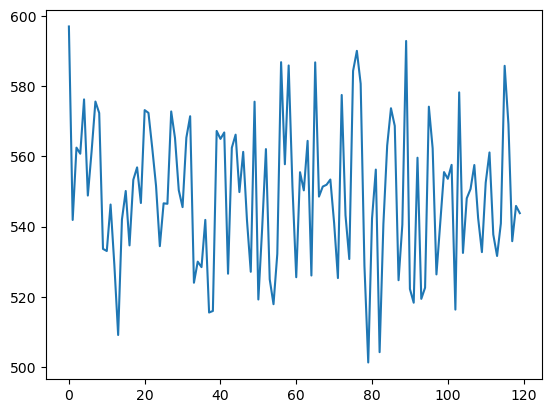

In [39]:
network, losses = train_autoencoder(surf, network, epochs, LR, wtd, batch, pint, device)
plt.plot(losses)

In [40]:
def extract_state_lists(state_dict, layer_prefixes):
    state_lists = []

    for layer_prefix in layer_prefixes:
        layer_list = [key for key in state_dict.keys() if layer_prefix in key and 'weight' in key]
        state = []

        for idx, key in enumerate(layer_list):
            weight_size = state_dict[key].size()
            state.append([weight_size[1], weight_size[0]])

        state_lists.append(state)

    return state_lists

def grow_network(network, losses, thresh_scale=0.8, width_scale=0.2):
    losses = torch.tensor(losses).detach().cpu()
    quarter_size = len(losses) // 4
    third_quarter_losses = losses[2 * quarter_size:3 * quarter_size]
    fourth_quarter_losses = losses[3 * quarter_size:]

    # Calculate mean losses for each quarter
    third_quarter_mean = third_quarter_losses.mean()
    fourth_quarter_mean = fourth_quarter_losses.mean()

    # Compare fourth quarter loss to threshold scaled third quarter loss
    if fourth_quarter_mean > third_quarter_mean * thresh_scale:
        print('Growing the network!')
        for layer_type in range(1, 5):
            feat_list = []
            for mo in network.get_layer_list(layer_type):
                feat_list.extend([mo.in_features, mo.out_features])
            a = feat_list[0]
            b = feat_list[-1] if len(feat_list) < 4 else feat_list[3]
            new_width = int(a * width_scale + b * (1 - width_scale))
            network.add_layer(layer_type, 0)
            network.change_width(layer_type, 0, new_width)
        
    return network

In [47]:
network = grow_network(network,losses)

Growing the network!


In [45]:
losses

[597.0010375976562,
 541.904052734375,
 562.4998779296875,
 560.7646484375,
 576.2357788085938,
 548.8546752929688,
 561.5260009765625,
 575.6270751953125,
 572.3585205078125,
 533.6629638671875,
 533.0588989257812,
 546.2968139648438,
 529.0645751953125,
 509.1368713378906,
 542.02099609375,
 550.1497192382812,
 534.6532592773438,
 553.3350830078125,
 556.8775024414062,
 546.7269287109375,
 573.1820678710938,
 572.3934936523438,
 562.3641357421875,
 551.5980224609375,
 534.4379272460938,
 546.6394653320312,
 546.5054321289062,
 572.8023071289062,
 565.2598266601562,
 550.3565063476562,
 545.5570068359375,
 565.3304443359375,
 571.4389038085938,
 524.0241088867188,
 530.0294799804688,
 528.4627685546875,
 541.9163208007812,
 515.5438232421875,
 515.9807739257812,
 567.2488403320312,
 564.979736328125,
 566.8211059570312,
 526.5917358398438,
 562.4662475585938,
 566.195556640625,
 549.8416748046875,
 561.2942504882812,
 541.7777099609375,
 527.1399536132812,
 575.58349609375,
 519.24938

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type                    | Params
-----------------------------------------------------------------
0  | activate            | LeakyReLU               | 0     
1  | loss_function       | Chamfer_Loss            | 0     
2  | e_layers1           | ModuleList              | 201   
3  | e_layers2           | ModuleList              | 523 K 
4  | d_layers1           | ModuleList              | 127 K 
5  | d_layers2           | ModuleList              | 127 K 
6  | encoder_layers      | TransformerEncoderLayer | 3.2 M 
7  | transformer_encoder | TransformerEncoder      | 6.3 M 
8  | decoder_layers      | TransformerDecoderLayer | 4.2 M 
9  | transformer_decoder | TransformerDecoder      | 8.4 M 
10 | pooler1             | AdaptiveMaxPool1d       | 0     
11 | pooler2       

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


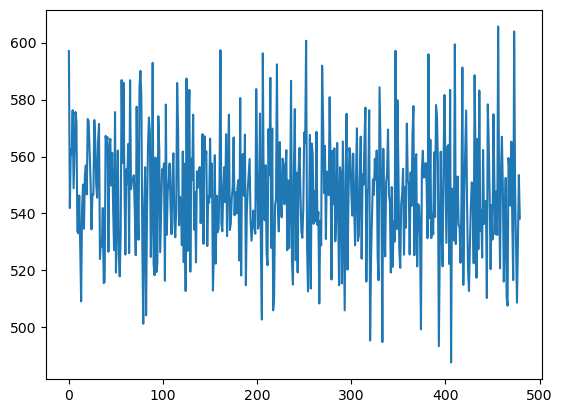

In [48]:
network, losses = train_autoencoder(surf, network, epochs, LR, wtd, batch, pint, device)
plt.plot(losses)